In [4]:
import pandas as pd

# Load your files
opensea_df = pd.read_csv("opensea_balanced_failed_transactions.csv")
sushiswap_df = pd.read_csv("sushiswap_balanced_failed_transactions.csv")
inch_df = pd.read_csv("1inch_balanced_failed_transactions.csv")

# Assign DApp names (if not already there)
opensea_df["dapp_name"] = "OpenSea"
sushiswap_df["dapp_name"] = "SushiSwap"
inch_df["dapp_name"] = "1inch"

# Combine and save
df = pd.concat([opensea_df, sushiswap_df, inch_df], ignore_index=True)
df.to_csv("combined_failed_transactions.csv", index=False)


In [2]:
import pandas as pd
import requests
import time
import json
import os
from datetime import datetime

# Load dataset
df = pd.read_csv("combined_failed_transactions.csv")
df["method_id"] = df["error_message_raw"].astype(str).str[:10]

# Load or create decoding cache
CACHE_FILE = "decoded_methods_cache.json"
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as f:
        signature_map = json.load(f)
else:
    signature_map = {}

# Deduplicate method_ids
unique_ids = df["method_id"].dropna().unique()
print(f"🔍 Found {len(unique_ids)} unique method IDs to decode.")

# API call function
def decode_method_id(method_id):
    url = f"https://www.4byte.directory/api/v1/signatures/?hex_signature={method_id}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            results = response.json().get("results", [])
            if results:
                return results[0]["text_signature"]
        return None
    except Exception as e:
        print(f"❌ Error decoding {method_id}: {e}")
        return None

# Begin decoding
success_count = 0
fail_count = 0
start_time = datetime.now()

try:
    for i, method_id in enumerate(unique_ids, 1):
        if method_id in signature_map:
            print(f"[{i}/{len(unique_ids)}] ✅ Cached: {method_id} → {signature_map[method_id]}")
            continue

        print(f"[{i}/{len(unique_ids)}] ⏳ Decoding {method_id}...")
        decoded = decode_method_id(method_id)
        signature_map[method_id] = decoded

        if decoded:
            print(f"    ✅ Success: {method_id} → {decoded}")
            success_count += 1
        else:
            print(f"    ⚠️  Not Found: {method_id}")
            fail_count += 1

        if i % 10 == 0:
            print(f"📊 Status: {i} checked | {success_count} decoded | {fail_count} not found")

        time.sleep(0.3)

except KeyboardInterrupt:
    print("⚠️ Stopped by user. Saving progress...")

finally:
    # Save cache
    with open(CACHE_FILE, "w") as f:
        json.dump(signature_map, f, indent=2)
    print("💾 Cache saved.")

    # Apply and export
    df["method_called"] = df["method_id"].map(signature_map)
    df.to_csv("decoded_failed_transactions.csv", index=False)

    duration = datetime.now() - start_time
    print(f"✅ Done. Decoded {success_count} / {len(unique_ids)}")
    print(f"🕒 Total time: {duration}")
    print("📁 Output: decoded_failed_transactions.csv")


🔍 Found 18 unique method IDs to decode.
[1/18] ✅ Cached: 0xab834bab → atomicMatch_(address[14],uint256[18],uint8[8],bytes,bytes,bytes,bytes,bytes,bytes,uint8[2],bytes32[5])
[2/18] ✅ Cached: 0x → mintForAirDrop(address[],uint256[])
[3/18] ✅ Cached: 0xa8a41c70 → cancelOrder_(address[7],uint256[9],uint8,uint8,uint8,uint8,bytes,bytes,bytes,uint8,bytes32,bytes32)
[4/18] ✅ Cached: 0xb37084fe → None
[5/18] ✅ Cached: 0x8803dbee → swapTokensForExactTokens(uint256,uint256,address[],address,uint256)
[6/18] ✅ Cached: 0x38ed1739 → swapExactTokensForTokens(uint256,uint256,address[],address,uint256)
[7/18] ✅ Cached: 0x7ff36ab5 → join_tg_invmru_haha_9d69f3f(bool,address)
[8/18] ✅ Cached: 0x18cbafe5 → join_tg_invmru_haha_617eab6(address,uint256,bool)
[9/18] ✅ Cached: 0x791ac947 → _SIMONdotBLACK_(int16,uint168,bytes10[],bool,uint40[])
[10/18] ✅ Cached: 0x2195995c → watch_tg_invmru_414645b(bool,bool,address)
[11/18] ✅ Cached: 0xfb3bdb41 → transfer_attention_tg_invmru_589df09(bool,bool,uint256)
[12/18] ✅ 

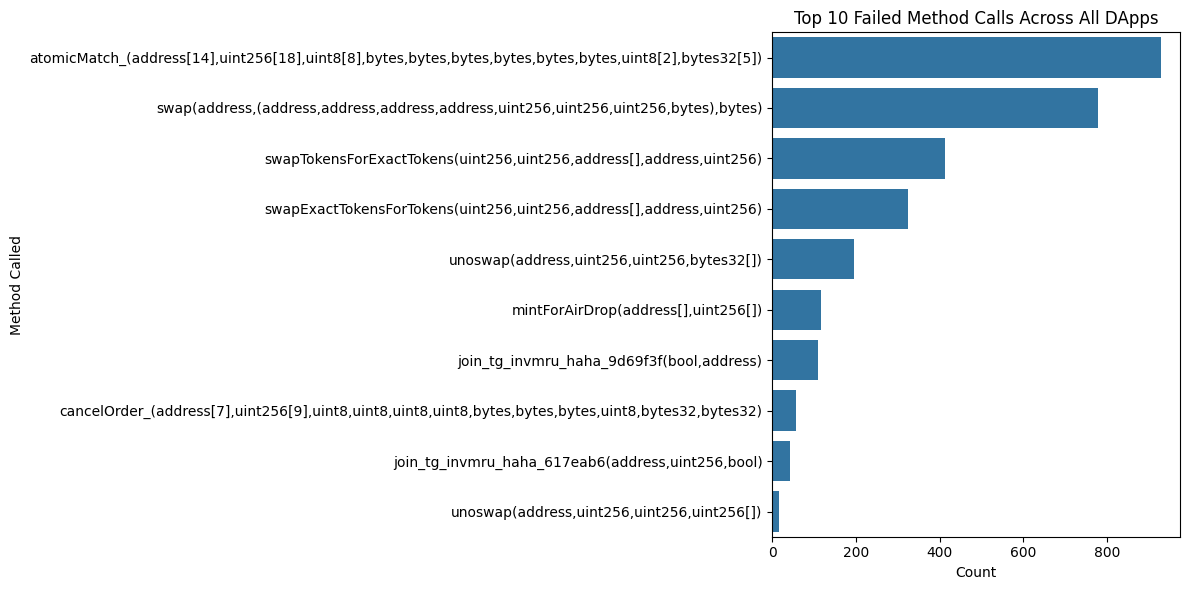

{'✅ Total Transactions': 3000,
 '✅ Transactions with Valid Decoded Method': 3000,
 '✅ Unique Decoded Methods': 18,
 '✅ Any Missing/Undecoded Methods': np.int64(0),
 '✅ Valid Timestamps Present': np.True_,
 "✅ 'input' Field Format OK (starts with 0x)": np.True_,
 '✅ method_id Extracted Correctly (starts with 0x)': np.True_,
 '✅ DApp Names Present': np.True_}

In [4]:
# Load the uploaded final preprocessed dataset
df = pd.read_csv("decoded_failed_transactions.csv")

# Preprocessing integrity checks
df["method_called"] = df["method_called"].astype(str).str.strip()
df_cleaned = df[df["method_called"].notna() & (df["method_called"] != "None") & (df["method_called"] != "")]

# Timestamp and ID checks
timestamp_valid = pd.to_datetime(df["timestamp"], errors="coerce").notna().all()
has_input = df["error_message_raw"].astype(str).str.startswith("0x").all()
has_method_id = df["method_id"].astype(str).str.startswith("0x").all()

# Summary of preprocessing validation
validation_summary = {
    "✅ Total Transactions": len(df),
    "✅ Transactions with Valid Decoded Method": len(df_cleaned),
    "✅ Unique Decoded Methods": df_cleaned["method_called"].nunique(),
    "✅ Any Missing/Undecoded Methods": df["method_called"].isna().sum() + (df["method_called"] == "None").sum(),
    "✅ Valid Timestamps Present": timestamp_valid,
    "✅ 'input' Field Format OK (starts with 0x)": has_input,
    "✅ method_id Extracted Correctly (starts with 0x)": has_method_id,
    "✅ DApp Names Present": "dapp_name" in df.columns and df["dapp_name"].notna().all(),
}

# Visual: Distribution of valid decoded methods
import matplotlib.pyplot as plt
import seaborn as sns

top_methods = df_cleaned["method_called"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, y="method_called", order=top_methods.index)
plt.title("Top 10 Failed Method Calls Across All DApps")
plt.xlabel("Count")
plt.ylabel("Method Called")
plt.tight_layout()
plt.show()

# Print summary results
validation_summary


In [ ]:
'''We started by gathering 3,000 unsuccessful Ethereum transactions from three high-volume DApps (OpenSea, 1inch, and SushiSwap) in a balanced sample.  Every transaction underwent the following preprocessing, cleaning, and timestamp alignment:

 4-byte method_id values were extracted by parsing the input field.

 To recover actual function signatures, these were decoded using the 4byte.directory API (e.g., swapExactTokensForTokens(uint256,uint256,address[],address,uint256)).

 All transactions had valid calldata with a 0x prefix, and all of them were successfully decoded.

 Every entry had DApp labels and was timestamp-valid, enabling per-DApp UX analysis.

 18 distinct approaches in all were found, serving as the basis for the UX taxonomy clustering that followed.
 '''

In [6]:
import pandas as pd
import numpy as np

# Load your decoded dataset
df = pd.read_csv("decoded_failed_transactions.csv")

#  Gas usage ratio: how much of the gas limit was actually consumed
df["gas_used_ratio"] = df["gas_used"] / df["gas_limit"]
df["gas_used_ratio"] = df["gas_used_ratio"].clip(0, 2.0)  # cap extreme outliers

# 🧮 Log of value sent (ETH): avoids skew from high-value txs
df["value_sent_eth"] = df["value_sent"].astype(float) / 1e18
df["value_log"] = np.log1p(df["value_sent_eth"])  # log(1 + x)

# Message length in characters: proxy for payload size or complexity
df["input_length"] = df["error_message_raw"].astype(str).apply(len)

# Cost intensity: gas efficiency × ETH value at stake
df["cost_intensity"] = df["value_sent_eth"] * df["gas_used_ratio"]

#  Time-based features
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour_of_day"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek  # 0 = Monday

#  Failure frequency per method (global failure context)
method_freq = df["method_called"].value_counts().to_dict()
df["method_failure_freq"] = df["method_called"].map(method_freq)

# Optional: bucket gas usage severity (ordinal encoding)
df["severity_bucket"] = pd.cut(df["gas_used_ratio"],
                               bins=[0, 0.5, 0.9, 1.5, np.inf],
                               labels=["low", "medium", "high", "extreme"])

# Save engineered data (optional)
df.to_csv("feature_engineered_failed_transactions.csv", index=False)
print("✅ Feature engineering complete. Output saved as 'feature_engineered_failed_transactions.csv'.")


✅ Feature engineering complete. Output saved as 'feature_engineered_failed_transactions.csv'.


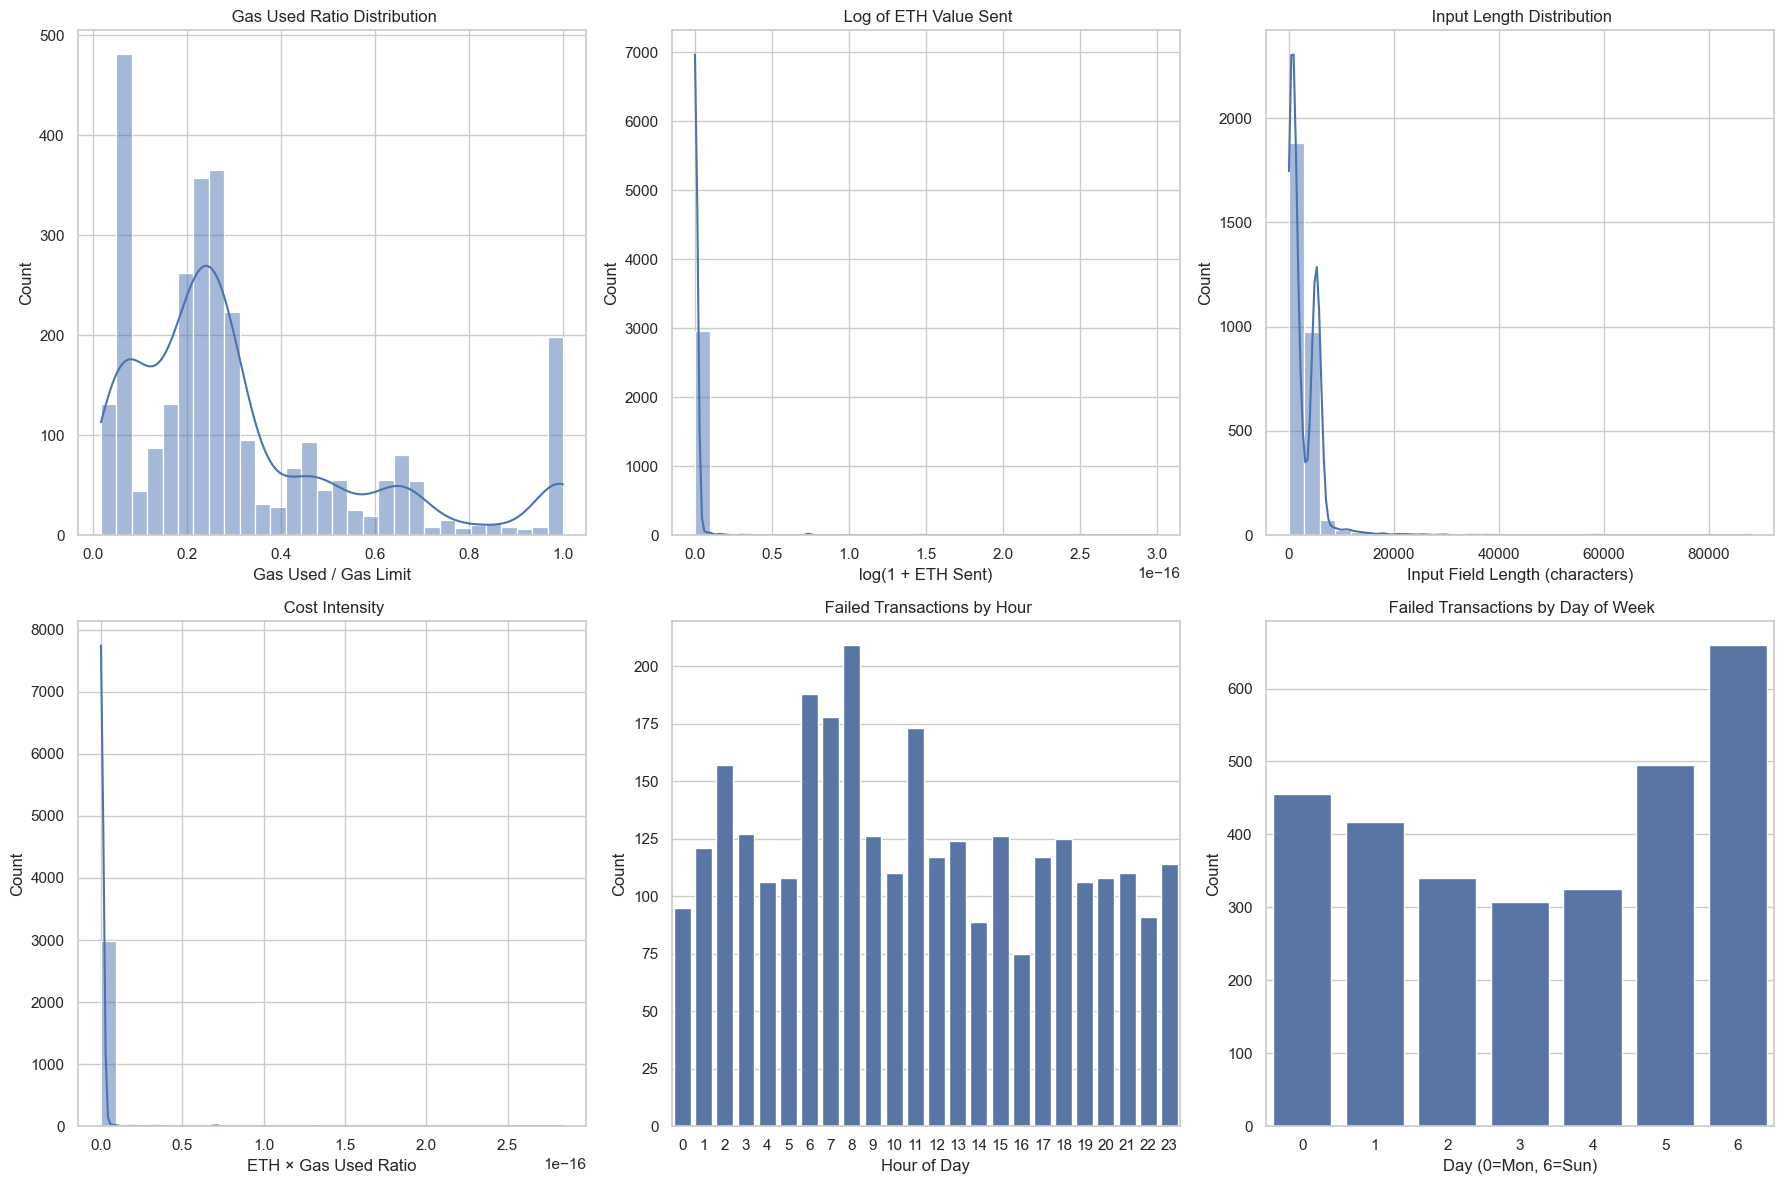

{'Unique severity levels': 3,
 'Unique hours observed': 24,
 'Unique days observed': 7,
 'Max gas_used_ratio': np.float64(1.0),
 'Max cost_intensity': np.float64(0.0),
 'Max value_log': np.float64(0.0)}

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature-engineered dataset
df = pd.read_csv("feature_engineered_failed_transactions.csv")

# Set visual style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# 1. Gas Used Ratio Distribution
plt.subplot(2, 3, 1)
sns.histplot(df["gas_used_ratio"], bins=30, kde=True)
plt.title(" Gas Used Ratio Distribution")
plt.xlabel("Gas Used / Gas Limit")

# 2. Log of Value Sent
plt.subplot(2, 3, 2)
sns.histplot(df["value_log"], bins=30, kde=True)
plt.title(" Log of ETH Value Sent")
plt.xlabel("log(1 + ETH Sent)")

# 3. Input Length Distribution
plt.subplot(2, 3, 3)
sns.histplot(df["input_length"], bins=30, kde=True)
plt.title(" Input Length Distribution")
plt.xlabel("Input Field Length (characters)")

# 4. Cost Intensity Distribution
plt.subplot(2, 3, 4)
sns.histplot(df["cost_intensity"], bins=30, kde=True)
plt.title(" Cost Intensity")
plt.xlabel("ETH × Gas Used Ratio")

# 5. Hour of Day
plt.subplot(2, 3, 5)
sns.countplot(x="hour_of_day", data=df)
plt.title(" Failed Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")

# 6. Day of Week
plt.subplot(2, 3, 6)
sns.countplot(x="day_of_week", data=df)
plt.title(" Failed Transactions by Day of Week")
plt.xlabel("Day (0=Mon, 6=Sun)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# Print a quick validation summary
validation_summary = {
    "Unique severity levels": df["severity_bucket"].nunique(),
    "Unique hours observed": df["hour_of_day"].nunique(),
    "Unique days observed": df["day_of_week"].nunique(),
    "Max gas_used_ratio": round(df["gas_used_ratio"].max(), 2),
    "Max cost_intensity": round(df["cost_intensity"].max(), 4),
    "Max value_log": round(df["value_log"].max(), 4),
}

validation_summary


/var/folders/1t/70v2rs6x0wg00mmv5d4j6ll40000gn/T/ipykernel_80089/1280115225.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


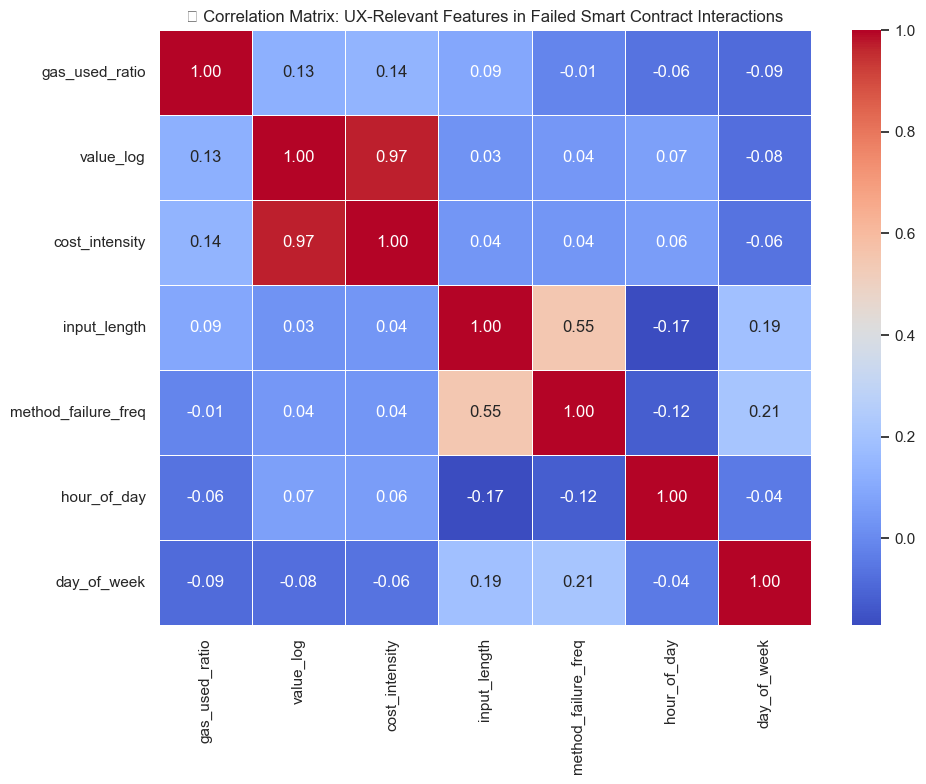

,gas_used_ratio,value_log,cost_intensity,input_length,method_failure_freq,hour_of_day,day_of_week
gas_used_ratio,1.000000,0.125612,0.136341,0.094190,-0.013223,-0.064200,-0.086194
value_log,0.125612,1.000000,0.970017,0.029961,0.043824,0.067295,-0.076543
cost_intensity,0.136341,0.970017,1.000000,0.038282,0.038535,0.057973,-0.063197
input_length,0.094190,0.029961,0.038282,1.000000,0.551090,-0.170934,0.187723
method_failure_freq,-0.013223,0.043824,0.038535,0.551090,1.000000,-0.124039,0.212487
hour_of_day,-0.064200,0.067295,0.057973,-0.170934,-0.124039,1.000000,-0.043634
day_of_week,-0.086194,-0.076543,-0.063197,0.187723,0.212487,-0.043634,1.000000


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the feature-engineered dataset
df = pd.read_csv("feature_engineered_failed_transactions.csv")

# Select only relevant numerical columns for correlation
correlation_features = [
    "gas_used_ratio",
    "value_log",
    "cost_intensity",
    "input_length",
    "method_failure_freq",
    "hour_of_day",
    "day_of_week"
]

# Compute correlation matrix
correlation_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(" Correlation Matrix: UX-Relevant Features in Failed Smart Contract Interactions")
plt.tight_layout()
plt.show()

# Also return the correlation matrix for inspection
correlation_matrix


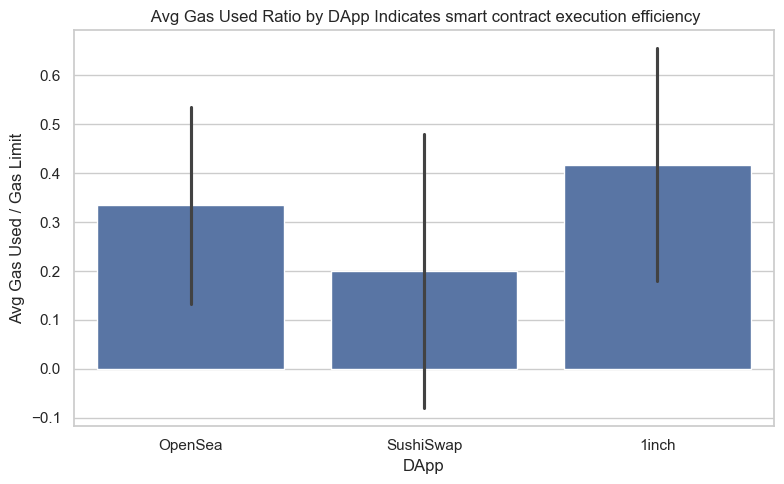

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("feature_engineered_failed_transactions.csv")

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot 1: Avg Gas Used Ratio by DApp
sns.barplot(x="dapp_name", y="gas_used_ratio", data=df, estimator="mean", errorbar='sd')
plt.title(" Avg Gas Used Ratio by DApp Indicates smart contract execution efficiency")
plt.xlabel("DApp")
plt.ylabel("Avg Gas Used / Gas Limit")
plt.tight_layout()
plt.show()


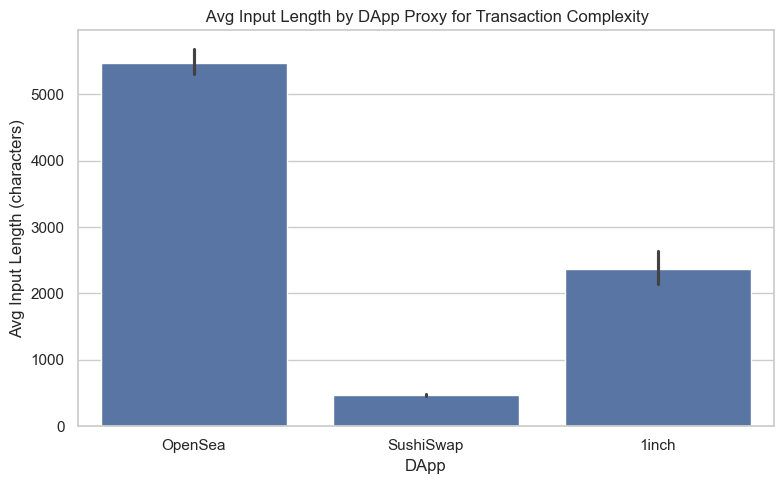

In [18]:
# Re-run with older, compatible syntax
plt.figure(figsize=(8, 5))
sns.barplot(x="dapp_name", y="input_length", data=df, estimator=np.mean)
plt.title(" Avg Input Length by DApp Proxy for Transaction Complexity")
plt.xlabel("DApp")
plt.ylabel("Avg Input Length (characters)")
plt.tight_layout()
plt.show()


/var/folders/1t/70v2rs6x0wg00mmv5d4j6ll40000gn/T/ipykernel_80089/2315634653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top["method_label"] = df_top["method_called"].map(method_mapping)


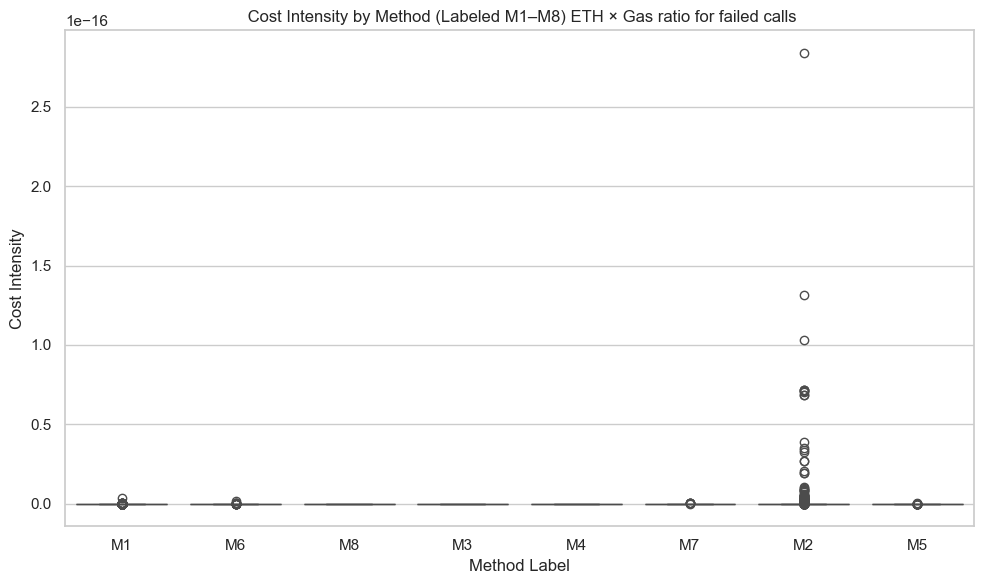

{'atomicMatch_(address[14],uint256[18],uint8[8],bytes,bytes,bytes,bytes,bytes,bytes,uint8[2],bytes32[5])': 'M1',
 'swap(address,(address,address,address,address,uint256,uint256,uint256,bytes),bytes)': 'M2',
 'swapTokensForExactTokens(uint256,uint256,address[],address,uint256)': 'M3',
 'swapExactTokensForTokens(uint256,uint256,address[],address,uint256)': 'M4',
 'unoswap(address,uint256,uint256,bytes32[])': 'M5',
 'mintForAirDrop(address[],uint256[])': 'M6',
 'join_tg_invmru_haha_9d69f3f(bool,address)': 'M7',
 'cancelOrder_(address[7],uint256[9],uint8,uint8,uint8,uint8,bytes,bytes,bytes,uint8,bytes32,bytes32)': 'M8'}

In [64]:
# Map method_called to short labels M1, M2, M3...
method_mapping = {method: f"M{i+1}" for i, method in enumerate(top_methods)}
df_top["method_label"] = df_top["method_called"].map(method_mapping)

# Plot with short labels
plt.figure(figsize=(10, 6))
sns.boxplot(x="method_label", y="cost_intensity", data=df_top)
plt.title(" Cost Intensity by Method (Labeled M1–M8) ETH × Gas ratio for failed calls")
plt.xlabel("Method Label")
plt.ylabel("Cost Intensity")
plt.tight_layout()
plt.show()

# Output method legend
method_mapping


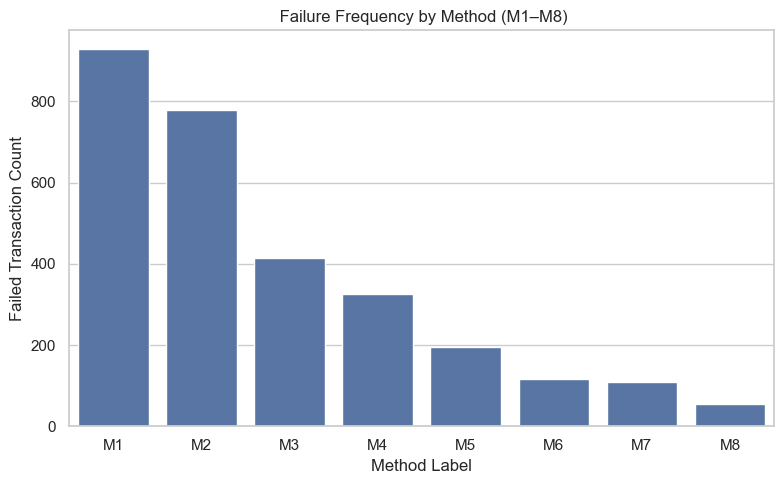

In [28]:
# Plot 4: Failure Frequency by Method (with M1–M8 labels)

# Use the same mapped labels
method_counts = df_top["method_label"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=method_counts.index, y=method_counts.values)
plt.title(" Failure Frequency by Method (M1–M8)")
plt.xlabel("Method Label")
plt.ylabel("Failed Transaction Count")
plt.tight_layout()
plt.show()


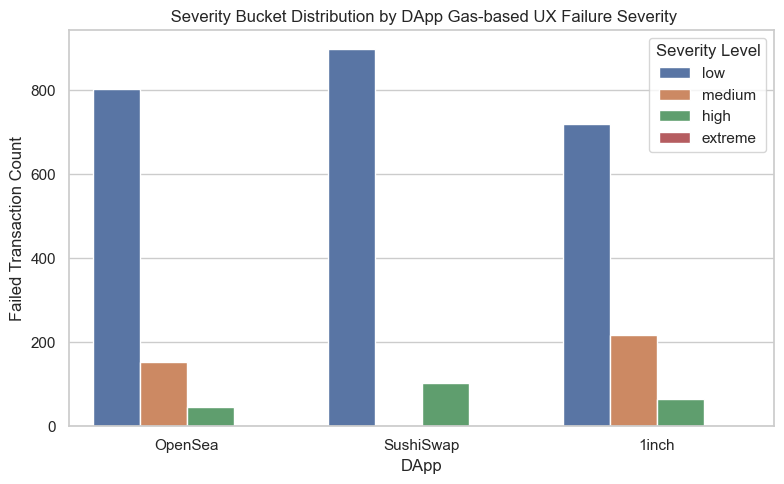

In [29]:
# Recreate the severity bucket column
df["severity_bucket"] = pd.cut(
    df["gas_used_ratio"],
    bins=[0, 0.5, 0.9, 1.5, float("inf")],
    labels=["low", "medium", "high", "extreme"]
)

# Now re-plot with valid severity data
plt.figure(figsize=(8, 5))
sns.countplot(x="dapp_name", hue="severity_bucket", data=df)
plt.title(" Severity Bucket Distribution by DApp Gas-based UX Failure Severity")
plt.xlabel("DApp")
plt.ylabel("Failed Transaction Count")
plt.legend(title="Severity Level")
plt.tight_layout()
plt.show()


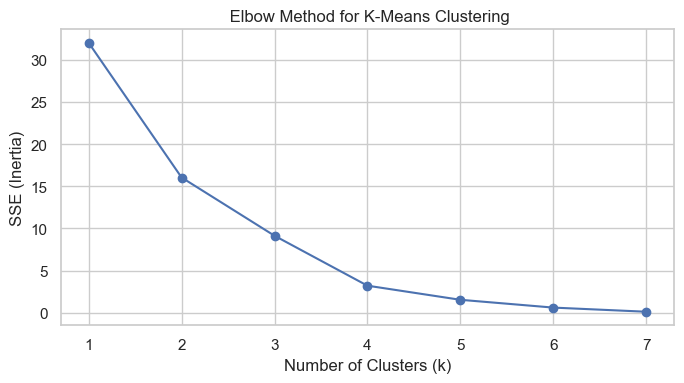

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Group by method and calculate features
method_cluster_data = df_top.groupby("method_called").agg({
    "gas_used_ratio": "mean",
    "input_length": "mean",
    "cost_intensity": "mean",
    "method_called": "count"
}).rename(columns={"method_called": "failure_count"})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(method_cluster_data)

# Elbow method to determine optimal K
sse = []
K_range = range(1, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    sse.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(7, 4))
plt.plot(K_range, sse, marker='o')
plt.title(" Elbow Method for K-Means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
method_cluster_data["cluster"] = kmeans_final.fit_predict(X_scaled)


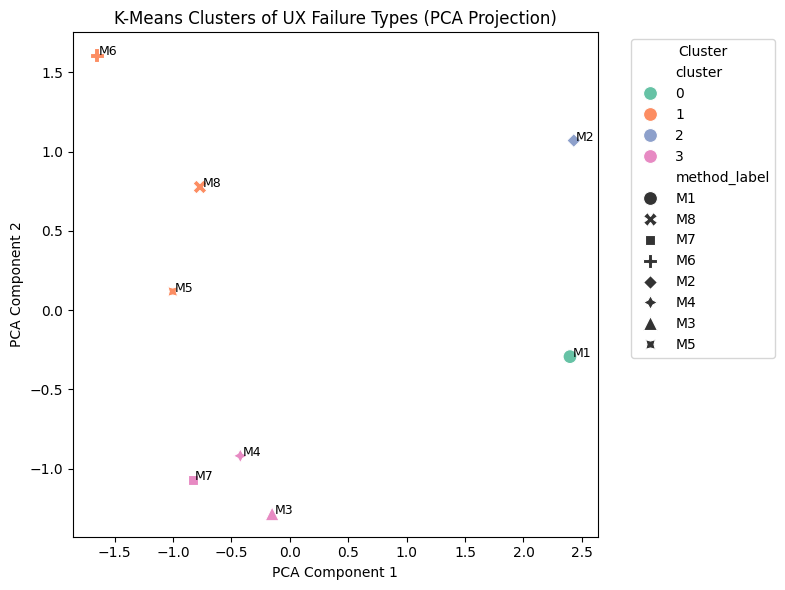

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the feature-engineered dataset
df = pd.read_csv("feature_engineered_failed_transactions.csv")

# Filter to ensure valid method names
df_cleaned = df[df["method_called"].notna() & (df["method_called"].str.strip() != "") & (df["method_called"] != "None")].copy()

# Dynamically label top 8 methods
top_methods = df_cleaned["method_called"].value_counts().head(8).index.tolist()
method_label_map = {method: f"M{i+1}" for i, method in enumerate(top_methods)}
df_cleaned.loc[:, "method_label"] = df_cleaned["method_called"].map(method_label_map)


# Group by method and aggregate feature metrics
method_cluster_data = df_cleaned[df_cleaned["method_called"].isin(top_methods)].groupby("method_called").agg({
    "gas_used_ratio": "mean",
    "input_length": "mean",
    "cost_intensity": "mean",
    "method_called": "count"
}).rename(columns={"method_called": "failure_count"})

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(method_cluster_data)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
method_cluster_data["cluster"] = kmeans.fit_predict(X_scaled)

# Run PCA for projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
method_cluster_data["PCA1"] = X_pca[:, 0]
method_cluster_data["PCA2"] = X_pca[:, 1]

# Add M1–M8 label to methods
method_cluster_data["method_label"] = method_cluster_data.index.map(method_label_map)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="cluster",
    data=method_cluster_data,
    palette="Set2",
    s=100,
    style="method_label"
)

# Annotate points
for i in range(method_cluster_data.shape[0]):
    row = method_cluster_data.iloc[i]
    plt.text(row["PCA1"] + 0.02, row["PCA2"], row["method_label"], fontsize=9)

plt.title("K-Means Clusters of UX Failure Types (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [68]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for the 4-cluster KMeans model
sil_score = silhouette_score(X_scaled, method_cluster_data["cluster"])

sil_score


np.float64(0.33985025485053366)

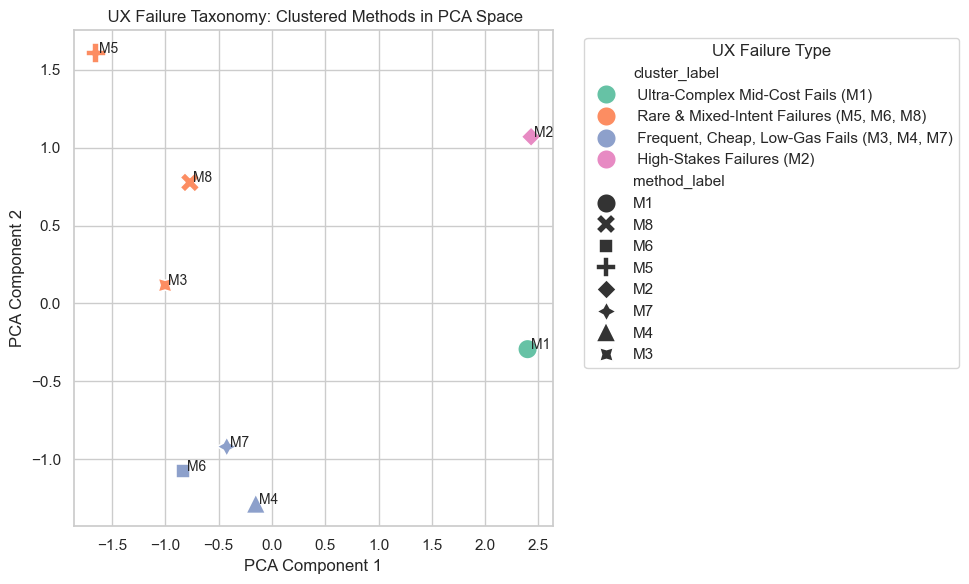

In [58]:
# Visualize taxonomy clusters as labeled boxes (category chart)
import matplotlib.pyplot as plt

# Set up basic taxonomy info
cluster_labels = {
    0: " Ultra-Complex Mid-Cost Fails (M1)",
    1: " Rare & Mixed-Intent Failures (M5, M6, M8)",
    2: " High-Stakes Failures (M2)",
    3: " Frequent, Cheap, Low-Gas Fails (M3, M4, M7)"
}

method_cluster_data["cluster_label"] = method_cluster_data["cluster"].map(cluster_labels)

# Plot taxonomy as annotated grid
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue="cluster_label",
    data=method_cluster_data,
    palette="Set2",
    s=200,
    style="method_label"
)

# Annotate each point with its method label (M1–M8)
for i in range(method_cluster_data.shape[0]):
    row = method_cluster_data.iloc[i]
    plt.text(row["PCA1"] + 0.03, row["PCA2"], row["method_label"], fontsize=10)

plt.title(" UX Failure Taxonomy: Clustered Methods in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="UX Failure Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [70]:
print(" Clusters assigned to:", method_cluster_data["cluster"].unique())
print(" Silhouette Score:", silhouette_score(X_scaled, method_cluster_data["cluster"]))
print(" Cluster counts:\n", method_cluster_data["cluster"].value_counts())
print(" Methods per cluster:\n", method_cluster_data[["method_label", "cluster"]])


 Clusters assigned to: [0 1 3 2]
 Silhouette Score: 0.33985025485053366
 Cluster counts:
 cluster
1    3
3    3
0    1
2    1
Name: count, dtype: int64
 Methods per cluster:
                                                    method_label  cluster
method_called                                                           
atomicMatch_(address[14],uint256[18],uint8[8],b...           M1        0
cancelOrder_(address[7],uint256[9],uint8,uint8,...           M8        1
join_tg_invmru_haha_9d69f3f(bool,address)                    M7        3
mintForAirDrop(address[],uint256[])                          M6        1
swap(address,(address,address,address,address,u...           M2        2
swapExactTokensForTokens(uint256,uint256,addres...           M4        3
swapTokensForExactTokens(uint256,uint256,addres...           M3        3
unoswap(address,uint256,uint256,bytes32[])                   M5        1


In [71]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, method_cluster_data["cluster"]))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, method_cluster_data["cluster"]))


Calinski-Harabasz Index: 11.977588796136267
Davies-Bouldin Index: 0.43210821250826875


In [2]:
import pandas as pd
import os

# Load your dataset
df = pd.read_csv("decoded_failed_transactions.csv")

# Filter valid decoded methods
df_cleaned = df[df["method_called"].notna() & (df["method_called"].str.strip() != "") & (df["method_called"] != "None")]

# Extract top 8 most frequent methods
top_methods = df_cleaned["method_called"].value_counts().head(8).index.tolist()

# Create M1–M8 label mapping
method_label_map = {method: f"M{i+1}" for i, method in enumerate(top_methods)}

# Ensure the output directory exists
os.makedirs("mapping", exist_ok=True)

# Save as CSV
mapping_df = pd.DataFrame(list(method_label_map.items()), columns=["method_called", "method_label"])
mapping_df.to_csv("mapping/method_label_map.csv", index=False)

print("✅ Mapping saved to mapping/method_label_map.csv")


✅ Mapping saved to mapping/method_label_map.csv
